In [1]:
# Feel free to add dependencies, but make sure that they are included in environment.yml

#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()

from sklearn import manifold
from openTSNE import TSNE
from umap import UMAP

c:\Programs\envs\xai_proj_space\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import pandas as pd

# Define board coordinates
board_size = 19
coordinates = [chr(97 + row) + chr(97 + col) for row in range(board_size) for col in range(board_size)]

# Define columns for the final DataFrame
columns = ["game_id", "move_id", "color", "our_players_color", "winner_color", "winner_score", "result", "rules", "handicap", "starter_player", "step_count"] + coordinates

# Initialize an empty DataFrame
all_games_df = pd.DataFrame(columns=columns)

# Helper functions
def parse_metadata_and_moves(sgf_content):
    moves = []
    # Determine rules and handicap
    rules = "Unknown"
    handicap = 0

    if "RU[" in sgf_content:
        rules = sgf_content.split("RU[")[1].split("]")[0]
    if "HA[" in sgf_content:
        handicap = int(sgf_content.split("HA[")[1].split("]")[0])
    
    # Determine winner information
    winner_color = "black" if "RE[B+" in sgf_content else "white"
    result = "resign" if "Resign" in sgf_content else "score"
    winner_score = None
    if result == "score":
        winner_score = sgf_content.split("RE[")[1].split("]")[0][2:]
    
    # Extract moves
    sgf_moves = sgf_content.split(";")[2:]  # Skip the first two header parts
    move_id = 1
    for move in sgf_moves:
        color = "black" if move.startswith("B") else "white"
        pos = move[2:4]
        moves.append((move_id, color, pos))
        move_id += 1
    
    # Determine starter player based on the first move
    starter_player = moves[0][1] if moves else "unknown"  # "unknown" if there are no moves
    return moves, winner_color, winner_score, result, rules, handicap, starter_player

# Initialize board with all 0s
def initialize_board():
    return {coord: 0 for coord in coordinates}

# Apply moves and log each step for a single game
def process_game(game_id, moves, winner_color, winner_score, result, our_players_color, rules, handicap, starter_player):
    board_state = initialize_board()
    data = []
    step_count = len(moves)

    for move_id, color, pos in moves:
        # Update board with current move
        board_state[pos] = 2 if color == "black" else 1  # 2 for Black, 1 for White
        row_data = {
            "game_id": game_id,
            "move_id": move_id,
            "color": color,
            "our_players_color": our_players_color,
            "winner_color": winner_color,
            "winner_score": winner_score,
            "result": result,
            "rules": rules,
            "handicap": handicap,
            "starter_player": starter_player,
            "step_count": step_count
        }
        row_data.update(board_state)
        data.append(row_data.copy())
        # Reset the stone to 0 for the next move
        board_state[pos] = 0
    return data

# Parse and process multiple SGF files in a folder
def process_sgf_folder(folder_path, our_players_color):
    global all_games_df
    game_id = 1
    for filename in os.listdir(folder_path):
        if filename.endswith(".sgf"):
            with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
                sgf_content = file.read()
            moves, winner_color, winner_score, result, rules, handicap, starter_player = parse_metadata_and_moves(sgf_content)
            game_data = process_game(game_id, moves, winner_color, winner_score, result, our_players_color, rules, handicap, starter_player)
            game_df = pd.DataFrame(game_data, columns=columns)
            all_games_df = pd.concat([all_games_df, game_df], ignore_index=True)
            game_id += 1

# Specify the folder path and the player's color
folder_path = "SGF"  # Update with the path to your folder
our_players_color = "black"  # Or "white", depending on the player  # HERE MAYBE WE SHOULD USE A KEY TABLE THAT WE WIL BUILD, AND JOIN THE 2 TABLES BY A KEY ID--------------------------------------------------------

# Process the SGF files
process_sgf_folder(folder_path, our_players_color)

# Save the merged DataFrame to an Excel file
output_path = "merged_games_data_new.xlsx"
all_games_df.to_excel(output_path, index=False)

print(f"Data saved to {output_path}")


In [3]:
import os
import re
import pandas as pd

# Define board coordinates
board_size = 19
coordinates = [chr(97 + row) + chr(97 + col) for row in range(board_size) for col in range(board_size)]

# Define columns for the final DataFrame
columns = ["game_id", "move_id", "color", "our_players_color", "winner_color", "winner_score", "result", "rules", "handicap", "starter_player", "step_count"] + coordinates

# Initialize an empty DataFrame
all_games_df = pd.DataFrame(columns=columns)

# Helper functions
def parse_metadata_and_moves(sgf_content):
    moves = []
    # Determine rules and handicap
    rules = "Unknown"
    handicap = 0

    if "RU[" in sgf_content:
        rules = sgf_content.split("RU[")[1].split("]")[0]
    if "HA[" in sgf_content:
        handicap = int(sgf_content.split("HA[")[1].split("]")[0])
    
    # Determine winner information
    winner_color = "black" if "RE[B+" in sgf_content else "white"
    result = "resign" if "Resign" in sgf_content else "score"
    winner_score = None
    if result == "score":
        winner_score = sgf_content.split("RE[")[1].split("]")[0][2:]
    
    # Extract moves
    sgf_moves = sgf_content.split(";")[2:]  # Skip the first two header parts
    move_id = 1
    for move in sgf_moves:
        color = "black" if move.startswith("B") else "white"
        pos = move[2:4]
        moves.append((move_id, color, pos))
        move_id += 1
    
    # Determine starter player based on the first move
    starter_player = moves[0][1] if moves else "unknown"  # "unknown" if there are no moves
    return moves, winner_color, winner_score, result, rules, handicap, starter_player

# Initialize board with all 0s
def initialize_board():
    return {coord: 0 for coord in coordinates}

# Apply moves and log each step for a single game
def process_game(game_id, moves, winner_color, winner_score, result, our_players_color, rules, handicap, starter_player):
    board_state = initialize_board()
    data = []
    step_count = len(moves)

    for move_id, color, pos in moves:
        # Update board with current move
        board_state[pos] = 2 if color == "black" else 1  # 2 for Black, 1 for White
        row_data = {
            "game_id": game_id,
            "move_id": move_id,
            "color": color,
            "our_players_color": our_players_color,
            "winner_color": winner_color,
            "winner_score": winner_score,
            "result": result,
            "rules": rules,
            "handicap": handicap,
            "starter_player": starter_player,
            "step_count": step_count
        }
        row_data.update(board_state)
        data.append(row_data.copy())
        # Reset the stone to 0 for the next move
        board_state[pos] = 0
    return data

# Parse and process multiple SGF files in a folder
def process_sgf_folder(folder_path, our_players_color):
    global all_games_df
    game_files = []

    # Gather files with their game IDs
    for filename in os.listdir(folder_path):
        if filename.endswith(".sgf"):
            # Extract the game ID from the filename using regex
            match = re.match(r"(\d+)_", filename)
            if match:
                game_id = int(match.group(1))
                game_files.append((game_id, filename))

    # Sort files by game_id
    game_files.sort(key=lambda x: x[0])

    # Process each file in sorted order
    for game_id, filename in game_files:
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as file:
            sgf_content = file.read()
        moves, winner_color, winner_score, result, rules, handicap, starter_player = parse_metadata_and_moves(sgf_content)
        game_data = process_game(game_id, moves, winner_color, winner_score, result, our_players_color, rules, handicap, starter_player)
        game_df = pd.DataFrame(game_data, columns=columns)
        all_games_df = pd.concat([all_games_df, game_df], ignore_index=True)

# Specify the folder path and the player's color
folder_path = "final\SGF"  # Update with the path to your folder
our_players_color = "black"  # Or "white", depending on the player

# Process the SGF files
process_sgf_folder(folder_path, our_players_color)

# Save the merged DataFrame to an Excel file
output_path = "merged_games_data_sorted2.xlsx"
all_games_df.to_excel(output_path, index=False)

print(f"Data saved to {output_path}")


Data saved to merged_games_data_sorted2.xlsx


In [4]:
# Load the score table
score_table_path = "final\Scores_key.xlsx"  # Update with your score table path
score_df = pd.read_excel(score_table_path)

# Rename 'ID' column in score table to 'game_id' to match main DataFrame
score_df = score_df.rename(columns={"Id": "game_id"})

# Merge the score table with all_games_df on 'game_id'
merged_df = pd.merge(all_games_df, score_df, on="game_id", how="left")

# Save the merged DataFrame to an Excel file
output_path = "merged_games_with_scores.xlsx"
merged_df.to_excel(output_path, index=False)

In [20]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load your dataset (assuming it's stored as a CSV)
data = pd.read_excel('merged_games_with_scores.xlsx')

# Selecting only the board state columns for dimensionality reduction
board_state_columns = data.loc[:, 'aa':'ss']
player_info_columns = data[['game_id', 'move_id', 'winner_color', 'level']]  # To keep track of each move/game info

# PCA Projection
pca = PCA(n_components=2)  # Project down to 2 dimensions
pca_result = pca.fit_transform(board_state_columns)
player_info_columns['PCA1'] = pca_result[:, 0]
player_info_columns['PCA2'] = pca_result[:, 1]




C:\Users\lengyel1lizb08\AppData\Local\Temp\ipykernel_2652\3243772323.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns['PCA1'] = pca_result[:, 0]
C:\Users\lengyel1lizb08\AppData\Local\Temp\ipykernel_2652\3243772323.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns['PCA2'] = pca_result[:, 1]


In [27]:
player_info_columns

,game_id,move_id,winner_color,level,PCA1,PCA2
0,1,1,white,1,-0.005835,-0.004293
1,1,2,white,1,-0.008986,-0.007227
2,1,3,white,1,-0.005671,-0.004089
3,1,4,white,1,-0.013199,-0.014130
4,1,5,white,1,-0.008695,-0.009537
...,...,...,...,...,...,...
5547,26,273,white,0,-0.005333,-0.003776
5548,26,274,white,0,-0.004258,-0.002734
5549,26,275,white,0,-0.004818,-0.003269
5550,26,276,white,0,-0.014640,-0.018910


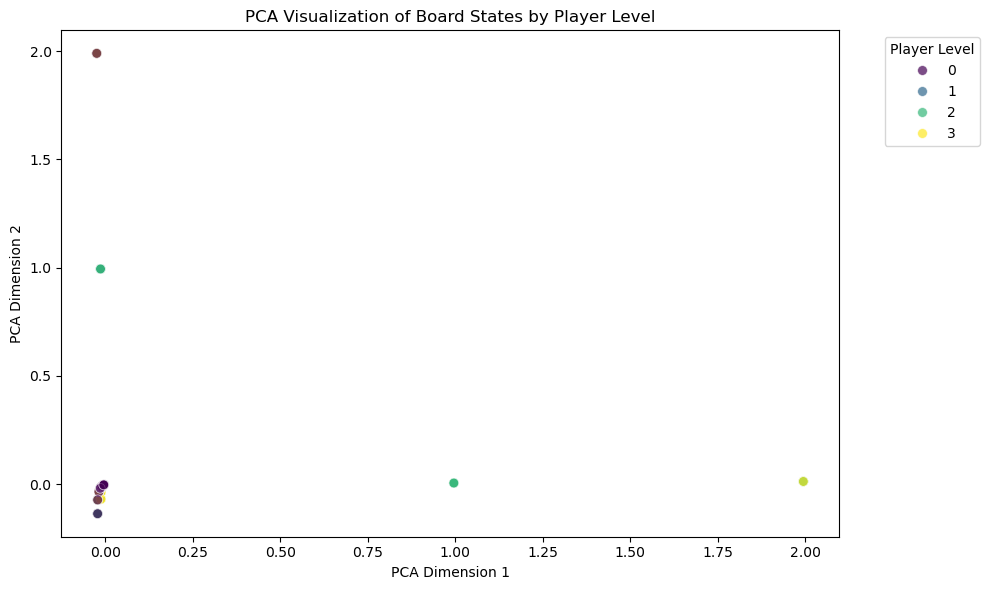

In [29]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='level',  # Color by player level
    palette='viridis',  # Color map (adjust as needed)
    data=player_info_columns,
    s=50,  # Marker size
    alpha=0.7  # Transparency
)

plt.title('PCA Visualization of Board States by Player Level')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Player Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

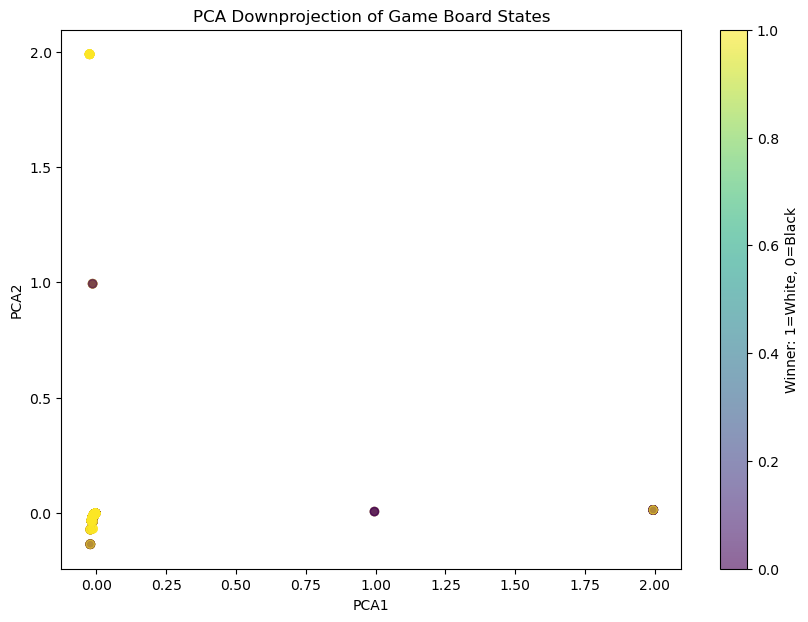

In [23]:
# Plotting PCA results
plt.figure(figsize=(10, 7))
plt.scatter(player_info_columns['PCA1'], player_info_columns['PCA2'], c=(player_info_columns['winner_color'] == 'white').astype(int), alpha=0.6)
plt.title('PCA Downprojection of Game Board States')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Winner: 1=White, 0=Black')
plt.show()

C:\Users\lengyel1lizb08\AppData\Local\Temp\ipykernel_2652\2931802779.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns['tSNE1'] = tsne_result[:, 0]
C:\Users\lengyel1lizb08\AppData\Local\Temp\ipykernel_2652\2931802779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns['tSNE2'] = tsne_result[:, 1]


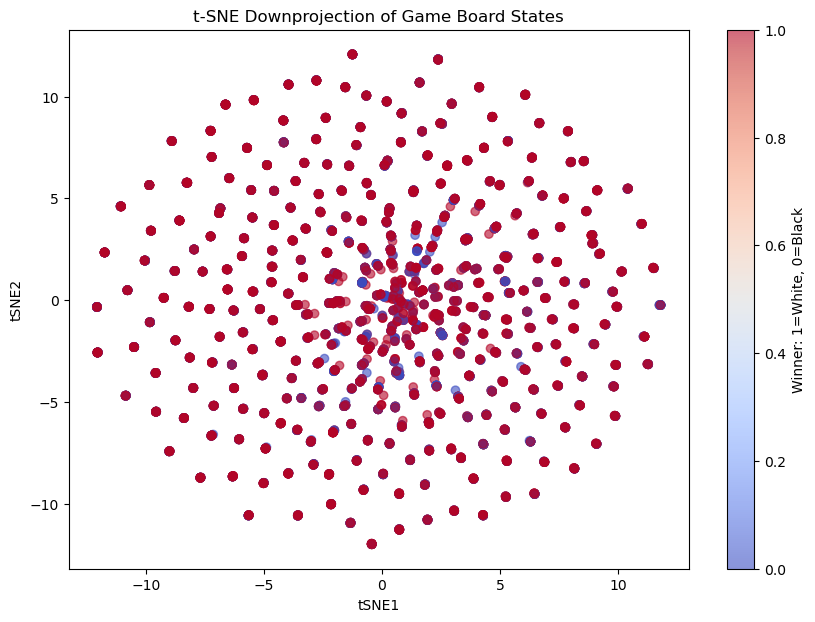

In [30]:
# t-SNE Projection
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(board_state_columns)
player_info_columns['tSNE1'] = tsne_result[:, 0]
player_info_columns['tSNE2'] = tsne_result[:, 1]

# Plotting t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(player_info_columns['tSNE1'], player_info_columns['tSNE2'], c=(player_info_columns['winner_color'] == 'white').astype(int), cmap='coolwarm', alpha=0.6)
plt.title('t-SNE Downprojection of Game Board States')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar(label='Winner: 1=White, 0=Black')
plt.show()

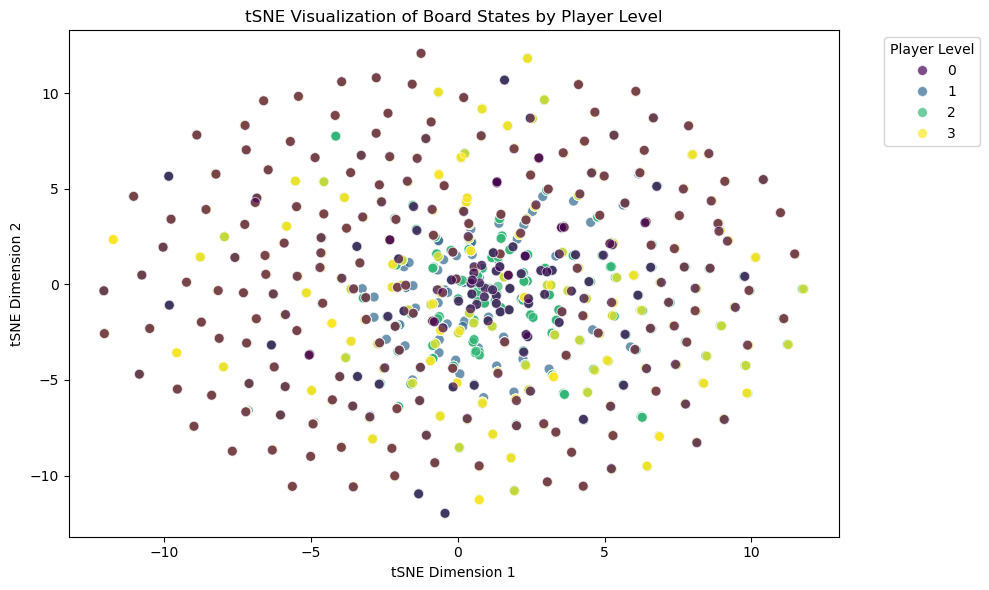

In [34]:
import seaborn as sns
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='tSNE1',
    y='tSNE2',
    hue='level',  # Color by player level
    palette='viridis',  # Color map (adjust as needed)
    data=player_info_columns,
    s=50,  # Marker size
    alpha=0.7  # Transparency
)

plt.title('tSNE Visualization of Board States by Player Level')
plt.xlabel('tSNE Dimension 1')
plt.ylabel('tSNE Dimension 2')
plt.legend(title='Player Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
alt.Chart(player_info_columns.query('move_id == 1')).mark_point(
    opacity=0.6
).encode(
    x='tSNE1',
    y='tSNE2',
    color='game_id:N',
    shape='level:N'
).properties(
    width=700,
    height=700,
    title="Projected Rubiks Cube States"
).interactive()

alt.Chart(...)

In [43]:
alt.Chart(player_info_columns.query('level == 2 & move_id < 10')).mark_line(
    opacity=0.6,
    point=alt.MarkConfig(size=200) 
).encode(
    x='tSNE1',
    y='tSNE2',
    color='game_id:N',
    shape='move_id:N',
    order='index:Q'
).properties(
    width=700,
    height=700,
    title="Paths of solving attempts"
).interactive()

alt.Chart(...)

In [12]:
player_info_columns

,game_id,move_id,winner_color,PCA1,PCA2,tSNE1,tSNE2
0,1,1,white,-0.005835,-0.004293,-9.758860,6.686062
1,1,2,white,-0.008986,-0.007227,-3.349956,9.941769
2,1,3,white,-0.005671,-0.004089,6.594093,-9.337440
3,1,4,white,-0.013199,-0.014130,-1.408265,-11.112536
4,1,5,white,-0.008695,-0.009537,-1.299780,1.585140
...,...,...,...,...,...,...,...
5547,26,273,white,-0.005333,-0.003776,-8.234944,7.262350
5548,26,274,white,-0.004258,-0.002734,-1.529892,-0.874472
5549,26,275,white,-0.004818,-0.003269,6.845467,4.925798
5550,26,276,white,-0.014640,-0.018910,-6.863420,-8.217338


In [15]:
player_info_columns.iloc[:, 5:]

,tSNE1,tSNE2
0,-9.758860,6.686062
1,-3.349956,9.941769
2,6.594093,-9.337440
3,-1.408265,-11.112536
4,-1.299780,1.585140
...,...,...
5547,-8.234944,7.262350
5548,-1.529892,-0.874472
5549,6.845467,4.925798
5550,-6.863420,-8.217338


In [17]:
alt.Chart(player_info_columns.iloc[:, 5:]).mark_circle(
    opacity=0.6
).encode(
    x='tSNE1',
    y='tSNE2',
).properties(
    width=500,
    height=400,
    title="Projected Rubiks Cube States"
).interactive()

alt.Chart(...)

C:\Users\lengyel1lizb08\AppData\Local\Temp\ipykernel_2652\2601128552.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns['UMAP1'] = umap_result[:, 0]
C:\Users\lengyel1lizb08\AppData\Local\Temp\ipykernel_2652\2601128552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info_columns['UMAP2'] = umap_result[:, 1]


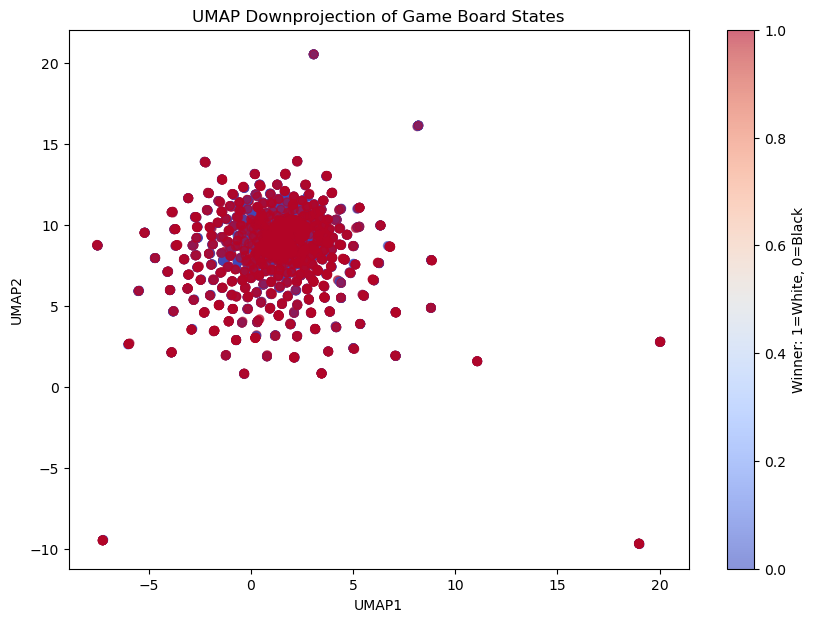

In [ ]:
import umap

# UMAP Projection
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_result = umap_model.fit_transform(board_state_columns)
player_info_columns['UMAP1'] = umap_result[:, 0]
player_info_columns['UMAP2'] = umap_result[:, 1]



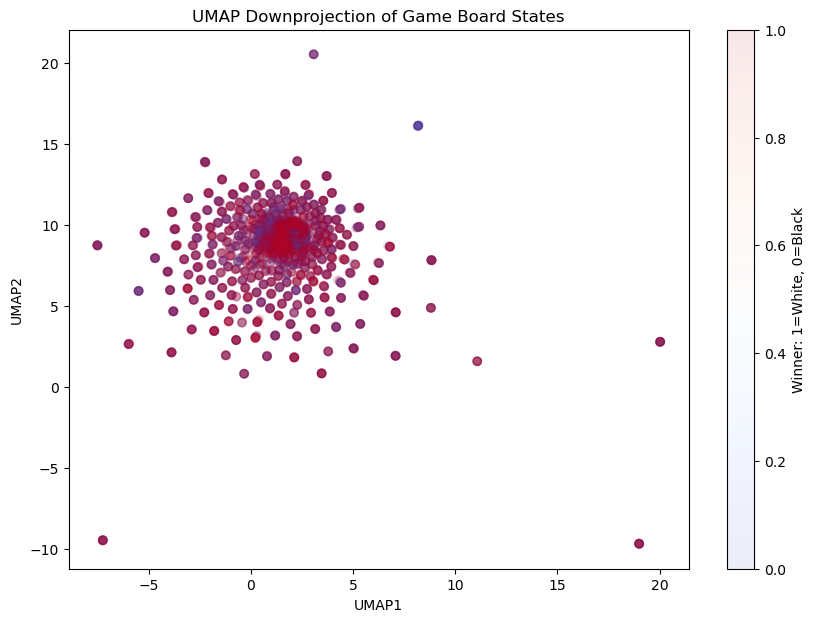

In [19]:
# Plotting UMAP results
plt.figure(figsize=(10, 7))
plt.scatter(player_info_columns['UMAP1'], player_info_columns['UMAP2'], c=(player_info_columns['winner_color'] == 'white').astype(int), cmap='coolwarm', alpha=0.1)
plt.title('UMAP Downprojection of Game Board States')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Winner: 1=White, 0=Black')
plt.show()